In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle

random.seed(17)
np.random.seed(17)

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)



Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Load data

In [3]:
train_path = "../../data/Santander/train_ver2.csv"

target_columns = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']
other_columns = ['fecha_dato', 'ncodpers'] 
all_columns = target_columns + other_columns

dtypes_columns = {}
for c in target_columns:
    dtypes_columns[c] = np.float16

#limit_rows = 50
limit_rows = 50000000

df = pd.read_csv(train_path, usecols=all_columns, dtype=dtypes_columns, nrows=limit_rows)
#df_train = pd.read_csv(train_path, usecols=all_columns,  nrows=limit_rows)
df['fecha_dato'] = pd.to_datetime(df['fecha_dato'])

# Data preprocessing and preparation

In [4]:
#for now, lets work only with a few ncodpers removing most of them
all_codpers = df['ncodpers'].unique()
print(len(all_codpers))
use_codpers = all_codpers[0:15000]
df = df[df.ncodpers.isin(use_codpers)]
print(len(df['ncodpers'].unique()))

956645
15000


In [5]:
#Replace NaN by 0
df['ind_nomina_ult1'].fillna(0, inplace=True)
df['ind_nom_pens_ult1'].fillna(0, inplace=True)

In [6]:
X_train = []
Y_train = []
X_test = []
Y_test = []
grouped = df.groupby('ncodpers')
seq_length = 5 # timesteps
test_date = df['fecha_dato'].unique()[-1]
for ncodpers,group in grouped:
    #if ncodpers == 1048484:
    for i in range(len(group)):
        if(group.iloc[i]['fecha_dato'] == test_date): #Add to test set
            #print('test in index ' + str(i) + ' fecha ' + str(group.iloc[i]['fecha_dato']))
            x = group[target_columns].values[(i-seq_length):i,:]
            y = group[target_columns].values[i,:]
            X_test.append(x)
            Y_test.append(y)
        else:
            if (i-seq_length) >= 0:
                #print('train in index ' + str(i) + ' fecha ' + str(group.iloc[i]['fecha_dato']))
                x = group[target_columns].values[(i-seq_length):i,:]
                y = group[target_columns].values[i,:]
                X_train.append(x)
                Y_train.append(y)
            #else:
                #print('Not enough data points past in index ' + str(i) + ' fecha ' + str(group.iloc[i]['fecha_dato']))


In [9]:
#Save pickle
with open('X_train.pickle', 'wb') as handle:
    pickle.dump(X_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('X_test.pickle', 'wb') as handle:
    pickle.dump(X_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Y_train.pickle', 'wb') as handle:
    pickle.dump(Y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Y_test.pickle', 'wb') as handle:
    pickle.dump(Y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
#Load pickle
with open('X_train.pickle', 'rb') as handle:
    X_train = pickle.load(handle)
with open('X_test.pickle', 'wb') as handle:
    pickle.dump(X_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Y_train.pickle', 'wb') as handle:
    pickle.dump(Y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Y_test.pickle', 'wb') as handle:
    pickle.dump(Y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
print(len(X_train))
print(len(X_test))

163123
14768


In [11]:
n_products = len(target_columns)

In [14]:
class DataSet():
    """
    Utility class to handle dataset structure.
    """

    def __init__(self, X_train, Y_train):

        assert len(X_train) == len(Y_train), (
              "images.shape: {0}, labels.shape: {1}".format(str(len(X_train)), str(len(Y_train))))

        self._num_examples = len(X_train)
        self._X_train = X_train
        self._Y_train = Y_train
        self._epochs_completed = 0
        self._index_in_epoch = 0


    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1

            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._X_train = self._X_train[perm]
            self._Y_train = self._Y_train[perm]

            start = 0
            self._epochs_completed = batch_size
            assert batch_size <= self._num_examples

        end = self._index_in_epoch
        return self._X_train[start:end], self._Y_train[start:end]
    
ds = DataSet(np.array(X_train), np.array(Y_train))
X_train = []
Y_train = []
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# TensorFlow Model 1

In [15]:
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
tf.reset_default_graph()

In [19]:
# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Network Parameters
n_input = n_products # data input
n_hidden = 64 # hidden layer num of features
n_output = n_products
n_classes = 2 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, seq_length, n_input], name='x')
y = tf.placeholder("float", [None, n_output], name='y')

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_output]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_output]))
}

In [20]:
def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # Permuting batch_size and n_steps
    
    x = tf.transpose(x, [1, 0, 2])
    
    
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    

    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    #x = tf.split(x, n_steps, 0)
    x = tf.split(split_dim=0, num_split=seq_length, value=x)


    # Define a lstm cell with tensorflow
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

    

    # Get lstm cell output
    #tf.nn.rnn(cell, inputs,#initial_state=self._initial_state)
    #outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    outputs, states = tf.nn.rnn(lstm_cell, x, dtype=tf.float32)


    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)




# Define loss and optimizer
pred_prob = tf.sigmoid(pred)
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
#correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
#accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()


In [ ]:
'''
N = len(X_train)
indices = list(range(N))
random.shuffle(indices)

current_idx = 0
def get_next_batch(batch_size):
    if (current_idx + batch_size) > N:
        batch_idx = indices[current_idx:]
        batch = X_train[batch_idx]
        current_idx = 0
        random.shuffle(indices)
        batch_idx = indices[current_idx:(batch_size-len(batch))]
        batch2 = X_train[batch_idx]
        current_idx = len(batch2)
        batch = np.concatenate((batch, batch2), axis=0)
    else:
        batch_idx = indices[current_idx:(current_idx + N)]
        batch = X_train[batch_idx]
'''
   




In [21]:

batch_size = 128
display_step = 50
# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    step = 1
    # Keep training until reach max iterations
    #while step * batch_size < training_iters:
    while ds._epochs_completed < 15:
        batch_x, batch_y = ds.next_batch(batch_size)
        # Reshape data 
        #batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        #batch_x = np.array(batch_x)
        #batch_y = np.array(batch_y)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        _, c = sess.run([optimizer, cost],
                                     feed_dict={x: batch_x, y: batch_y})
        
        
        if step % display_step == 0:
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + 
                  "{:.6f}".format(loss))
            # Calculate test loss
            test_loss = sess.run(cost, feed_dict={x:X_test, y:Y_test})
            print('Test loss: ' + str(test_loss))
            
            
        step += 1
    print("Optimization Finished!")
    
    # Calculate test loss
    test_loss = sess.run(cost, feed_dict={x: X_test, y: Y_test})
    print('Test loss: ' + str(test_loss))
    pred_test = sess.run(pred_prob, feed_dict={x: X_test, y: Y_test})

    

Iter 6400, Minibatch Loss= 0.018866
Test loss: 0.0390912
Iter 12800, Minibatch Loss= 0.014244
Test loss: 0.0293884
Iter 19200, Minibatch Loss= 0.011368
Test loss: 0.0257534
Iter 25600, Minibatch Loss= 0.008786
Test loss: 0.0180661
Iter 32000, Minibatch Loss= 0.015024
Test loss: 0.0158866
Iter 38400, Minibatch Loss= 0.000957
Test loss: 0.0141519
Iter 44800, Minibatch Loss= 0.003240
Test loss: 0.0138425
Iter 51200, Minibatch Loss= 0.002033
Test loss: 0.0125525
Iter 57600, Minibatch Loss= 0.006772
Test loss: 0.0123771
Iter 64000, Minibatch Loss= 0.009005
Test loss: 0.0117658
Iter 70400, Minibatch Loss= 0.016583
Test loss: 0.0121778
Iter 76800, Minibatch Loss= 0.009686
Test loss: 0.0114045
Iter 83200, Minibatch Loss= 0.009101
Test loss: 0.010247
Iter 89600, Minibatch Loss= 0.052572
Test loss: 0.00927192
Iter 96000, Minibatch Loss= 0.032381
Test loss: 0.00892316
Iter 102400, Minibatch Loss= 0.001057
Test loss: 0.008563
Iter 108800, Minibatch Loss= 0.009624
Test loss: 0.0085932
Iter 115200, 

# Look predictions

In [22]:
pred_test

array([[  1.02888953e-05,   1.48407034e-05,   9.97903705e-01, ...,
          4.66629164e-04,   6.25047600e-04,   2.54712254e-03],
       [  1.02888953e-05,   1.48407034e-05,   9.97903705e-01, ...,
          4.66629164e-04,   6.25047600e-04,   2.54712254e-03],
       [  1.02888953e-05,   1.48407034e-05,   9.97903705e-01, ...,
          4.66629164e-04,   6.25047600e-04,   2.54712254e-03],
       ..., 
       [  1.02888953e-05,   1.48407034e-05,   9.97903705e-01, ...,
          4.66629164e-04,   6.25047600e-04,   2.54712254e-03],
       [  1.02888953e-05,   1.48407034e-05,   9.97903705e-01, ...,
          4.66629164e-04,   6.25047600e-04,   2.54712254e-03],
       [  1.02888953e-05,   1.48407034e-05,   9.97903705e-01, ...,
          4.66629164e-04,   6.25047600e-04,   2.54712254e-03]], dtype=float32)

In [83]:
threshold = 0.5
y_pred = pred_test > threshold

Confusion matrix, without normalization
[[336594    279]
 [   498  17061]]
Normalized confusion matrix
[[  9.99171795e-01   8.28205288e-04]
 [  2.83615240e-02   9.71638476e-01]]


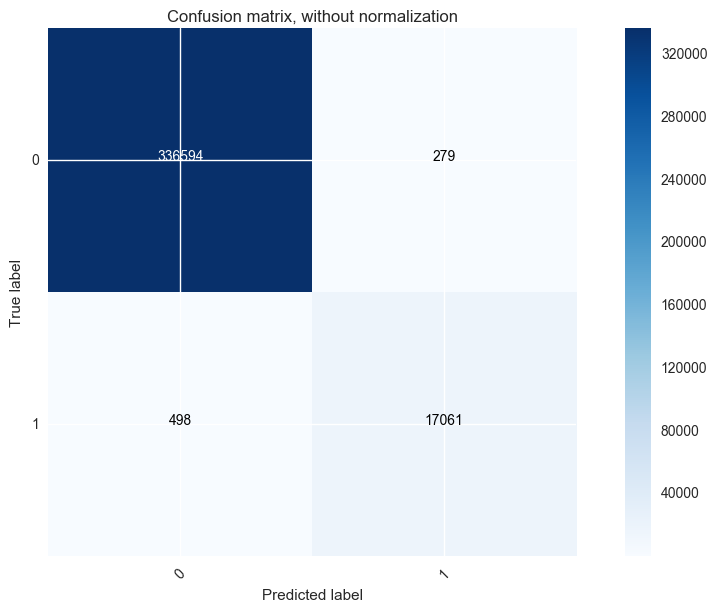

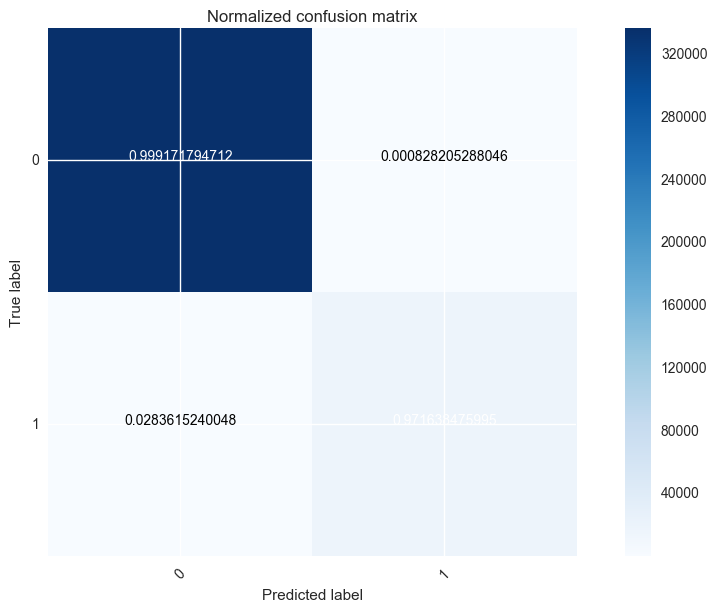

In [95]:
from sklearn.metrics import confusion_matrix
import itertools

class_names = [0,1]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

cnf_matrix = confusion_matrix(Y_test.reshape(1, -1)[0], y_pred.reshape(1, -1)[0])

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [43]:
pred_test[700]

array([  3.76217686e-05,   3.12186967e-05,   1.49079189e-02,
         3.85707332e-04,   8.26100528e-01,   2.21822716e-04,
         6.45757609e-05,   3.27336056e-06,   1.47278115e-05,
         3.48096801e-05,   6.73349656e-04,   1.59657036e-04,
         9.96843213e-04,   5.20675821e-05,   1.18819089e-05,
         3.13026190e-04,   3.63278705e-05,   1.79450288e-02,
         4.56716458e-04,   2.14787596e-03,   2.95954582e-04,
         2.01372802e-01,   2.99640328e-01,   3.80368382e-02], dtype=float32)

In [41]:
Y_test[700]

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float16)

In [44]:
X_test[700]

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float16)

In [67]:
idx_diff = []
for i in range(len(Y_test)):
    if not np.array_equal(Y_test[i], Y_test[0]):
        idx_diff.append(i)

In [68]:
idx_diff

[16,
 21,
 22,
 29,
 31,
 41,
 42,
 48,
 51,
 65,
 73,
 80,
 104,
 118,
 122,
 125,
 139,
 144,
 150,
 156,
 168,
 169,
 182,
 191,
 200,
 204,
 215,
 244,
 252,
 260,
 278,
 294,
 299,
 300,
 311,
 342,
 343,
 380,
 391,
 395,
 396,
 408,
 410,
 412,
 418,
 441,
 446,
 450,
 452,
 453,
 455,
 467,
 470,
 475,
 476,
 479,
 481,
 482,
 486,
 487,
 488,
 489,
 490,
 491,
 492,
 494,
 495,
 499,
 501,
 502,
 503,
 506,
 507,
 508,
 510,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 518,
 522,
 525,
 533,
 541,
 548,
 576,
 586,
 587,
 592,
 598,
 612,
 618,
 649,
 654,
 655,
 657,
 664,
 672,
 683,
 685,
 699,
 700,
 704,
 708,
 718,
 729,
 734,
 740,
 747,
 750,
 756,
 773,
 790,
 809,
 821,
 853,
 860,
 873,
 890,
 898,
 901,
 907,
 914,
 937,
 953,
 981,
 997,
 1021,
 1069,
 1075,
 1113,
 1135,
 1143,
 1156,
 1160,
 1161,
 1162,
 1163,
 1186,
 1191,
 1213,
 1238,
 1249,
 1283,
 1289,
 1301,
 1316,
 1324,
 1337,
 1357,
 1365,
 1406,
 1465,
 1466,
 1472,
 1486,
 1487,
 1491,
 1492,
 1506,
 

In [85]:
sample = 252
for i in range(len(Y_test[sample])):
    print('True label: ' + str(Y_test[sample,i]) + '- probability of True: ' + str(pred_test[sample,i]))

True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 1.0- probability of True: True
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of True: False
True label: 0.0- probability of T

In [71]:
pred_test[16]

array([  3.04176865e-07,   3.80806364e-06,   9.96303320e-01,
         3.97644362e-06,   6.18057442e-04,   1.43713987e-06,
         5.67435563e-05,   1.60640157e-05,   2.06890050e-04,
         2.27704240e-05,   2.87758525e-07,   4.08523425e-04,
         8.87364507e-01,   7.86612582e-05,   3.96499263e-06,
         7.92502135e-04,   2.13307685e-05,   2.12702711e-04,
         4.37480368e-04,   5.78749168e-04,   2.45743373e-04,
         4.37858747e-04,   8.90014227e-04,   8.97308905e-03], dtype=float32)